In [1]:
'''
Author: Phillip Monin and Rick Bookstaber
First version: August 1, 2013
Written and tested in Python 2.7.8 |Anaconda 2.1.0 (64-bit)| (default, Jul  2 2014, 15:12:11) [MSC v.1500 64 bit (AMD64)] on win32

A main difference from 34 and 36 is that the diagonal of the adjacency matrix is all 0s
in 34 and 36, while it is all 1s in 37 to reflect the approach of the paper.

Analytics v0004 is modified to reflect 1s on the diagonal, e.g. total connections is the sum
of the entries in (M-I), not M. 

Version 38 fixes an error with tribal preference.

Version 39 incorporates the "village" notion from 4/21/2015.

Version 41 allows for python to pick the seed randomly if 'theSeed' is set to 'random'


*************************************************************************
Update: Kevin Jones kevin.kemps.jones@gmail.com (for questions)
Sept 4 2020
The code was ported to python3. I had to make the following changes:
*modify the csv away from a byte stream
*networkx was updated, and doesn't support iterables
*the .node in networkx changed to .nodes
*I changed the code to just use range of the length of the dictionary to accomodate changes in 3.8< code around key use
*xrange was replaced with range

It's important to note, I used python 3.8.3, in jupyter notebook in a mint Linux environment.
If this code gets spread, it may be worth thinking about getting it into a virtualized env
If the code is widely used, it's probably worth thinking about parallelizing models

'''

'\nAuthor: Phillip Monin and Rick Bookstaber\nFirst version: August 1, 2013\nWritten and tested in Python 2.7.8 |Anaconda 2.1.0 (64-bit)| (default, Jul  2 2014, 15:12:11) [MSC v.1500 64 bit (AMD64)] on win32\n\nA main difference from 34 and 36 is that the diagonal of the adjacency matrix is all 0s\nin 34 and 36, while it is all 1s in 37 to reflect the approach of the paper.\n\nAnalytics v0004 is modified to reflect 1s on the diagonal, e.g. total connections is the sum\nof the entries in (M-I), not M. \n\nVersion 38 fixes an error with tribal preference.\n\nVersion 39 incorporates the "village" notion from 4/21/2015.\n\nVersion 41 allows for python to pick the seed randomly if \'theSeed\' is set to \'random\'\n\n\n*************************************************************************\nUpdate: Kevin Jones kevin.kemps.jones@gmail.com (for questions)\nSept 4 2020\nThe code was ported to python3. I had to make the following changes:\n*modify the csv away from a byte stream\n*networkx was

In [2]:
from __future__ import print_function
from __future__ import division

import os, inspect, shutil, csv, pickle, sys
#import cPickle as pickle
import networkx as nx
#import scipy as sp
import numpy as np
import pandas as pd
from scipy.stats import describe
import time
from random import seed, uniform, choice, gauss, randint
from math import fabs
import time
# import PyTables
#import h5py
import tables

##import matplotlib.pyplot as plt
##from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def total_connections_normalized(adj, normalized=True):
    r'''
    Computes time series of total connections. For each time t, sums over entries
    of adjacency matrix at that time.
    
    Parameters:
    -----------
    adj: (numTotalTicks,numAgents,numAgents)-numpy array
        time series of adjacency matrices
        
    Returns:
    ----------
    total_connections: (numTotalTicks)-numpy array
        time series of total connections
    '''
    tc = np.zeros(adj.shape[0])
    for i in range(adj.shape[0]):
#        tc[i] = (adj[i,:,:]-np.identity(adj.shape[1])).sum()
        tc[i] = (adj[i,:,:]-np.identity(adj.shape[1])).sum()
    
    if normalized == True:
        return tc / (adj.shape[1]*(adj.shape[1]-1))
    else:
        return tc

In [4]:
def categorize_state(tc, bust_pct = 0.40, boom_pct = 0.60):
    r'''
    For a given time series of total connections and bust and boom quantile cutoffs,
    returns a time series of the state: 1 for bust, 2 for middling, 3 for boom.
    
    Quantiles here are the quantiles of the range of total connections, a proportion
    of the maximum value of total connections (generally will be N*(N-1) for N agents)
    
    Parameters:
    ----------
    tc: (numTotalTicks)-numpy array
        time series of total connections
    bust_pct: float between 0 and 1
        bust quantile cutoff. If the quantile of total connections in a given period
        is less than or equal to bust_pct, then the state is considered a bust state.
    boom_pct: float between 0 and 1
        boom quantile cutoff. If the quantile of total connections in a given period
        is greater than boom_pct, then the state is considered a boom state.
    
    Returns:
    ----------
    categorize_state: (numTotalTicks)-numpy array
        each state is binned as a boom, bust, or "middling" state
        1 = bust; 2 = middling; 3 = boom
    '''
    maxconnections = max(tc)
    return np.asarray(pd.cut(tc, [0, bust_pct*maxconnections, 
                       boom_pct*maxconnections, maxconnections],
                       labels=[1,2,3]))

In [5]:
def crashes(tc, bust_pct = 0.40, boom_pct = 0.60):
    r'''
    For a given time series of total connections (and bust and boom quantiles),
    returns the number of crashes, i.e. number of [3,2,1] sequences.
    '''
    # categorize states into bust(1), middling(2), boom(3)
    maxconnections = max(tc)
    p = pd.cut(tc, [0, bust_pct*maxconnections, 
                       boom_pct*maxconnections, maxconnections],
                       labels=[1,2,3])
    # extract only number of state changes
    y = []
    y.append(p[0])
    for i in range(1, len(p)):
        if p[i] != p[i-1]:
            y.append(p[i])
    # produce list of state change triples (to search for [3,2,1] as an element)
    sct = [ y[i:i+3] for i in range(0, len(y)) ]
    return sct.count([3,2,1])

In [6]:
def expost_boom_bust_classifier_tc2(df_tc, df_a_50):
    df = pd.concat([df_tc, df_a_50], axis=1)
    df['boom_or_bust'] = categorize_state(df['tc'], bust_pct = 0.40, boom_pct = 0.60)

    p = df['boom_or_bust'].values
    # extract only number of state changes
    y = []
    y.append(p[0])
    for i in range(1, len(p)):
        if p[i] != p[i-1]:
            y.append(p[i])
    # produce list of state change triples (to search for [3,2,1] as an element)
    sct = [ y[i:i+3] for i in range(0, len(y)) ]
    
    t = df[['a_50','boom_or_bust']].values
    
    # the list 'b' will store boom and bust info (boom or bust, min/max median age,)
    b = []
    m = 0
    n = 1e15
    for i in range(t.shape[0]):
        # if in a boom state, track max age.
        if t[i,1] == 3:
            m = max(t[i,0], m)
            # if previously in a bust (i.e. n != 1e15), then record bust, min during bust, and time
            if n != 1e15:
                b.append(['bust', n, i])
                # reset n to 1e15
                n = 1e15
        # if in a bust state, track min age                
        elif t[i,1] == 1:
            n = min(t[i,0], n)
            # if previously in a boom (i.e. m != 0), then record boom, max during boom, and time
            if m != 0:
                b.append(['boom', m, i])
                # reset m to zero
                m = 0
    
    # need to account for last state; if above loop ends on a boom or bust, it won't record it
    if t[t.shape[0]-1,1] == 3:
        b.append(['boom', m, i])
    elif t[t.shape[0]-1,1] == 1:
        b.append(['bust', n, i])

    # produce list 'c' of crash sizes
    c = []
    for i in range(len(b) - 1):
        if (b[i][0] == 'boom') & (b[i+1][0] == 'bust'):
            c.append(b[i][1] - b[i+1][1])

    print(b)
    
    print(c)
                        
    return b, df['boom_or_bust'], sct.count([3,2,1]), np.array(c)

In [7]:
def total_crashes(b_master):
    # produce list 'c' of crash sizes
    b = b_master
    c = []
    for i in range(len(b) - 1):
        if (b[i][0] == 'boom') & (b[i+1][0] == 'bust'):
            c.append(b[i][1] - b[i+1][1])
            
    return c

def analytics_run_within_file(ages, total_connections, fname, iteration, k_star=0.60):

    ## TIME SERIES STATISTICS
    print('tc,dc')

    tc = total_connections
    df_tc = pd.DataFrame(total_connections, columns=['tc'])
    
    ages_pct = np.percentile(ages, axis = 1, q = [50]).transpose()
    df_a_pct = pd.DataFrame(data=ages_pct, columns=['a_50'])

    print('boom-bust classifier')
    b, df_boom_bust, num_crashes, crash_sizes = expost_boom_bust_classifier_tc2(df_tc, df_a_pct['a_50'])
    
    
    return b, crash_sizes

In [22]:
class modelRun:

    def __init__(self, theSeed, numAgents, numVillageAgents, numTotalTicks, probLink, updateSlope,
                 updatePerturbStDev,kStar,probDeathInter,
                 probDeathCoef,probDeathExponent,tribalPreferenceProb,numSegments):
        
        ## User inputs / Parameters of the model
        if theSeed == 'random':
            self.theSeed = randint(1,1000000000000000)
        else:
            self.theSeed = int(theSeed)  # the random number seed
        
        self.numAgents = int(numAgents)              # Number of agents in model (positive integer)
        self.numVillageAgents = int(numVillageAgents)        
        self.numTotalTicks = int(numTotalTicks)        # Number of periods to run model (positive integer)
        self.probLink = float(probLink)            # Probability of making a connection in a time period (real in [0,1])
        self.updateSlope = float(updateSlope)
        self.updatePerturbStDev = float(updatePerturbStDev)   # Slope parameter of the agent's update function (nonnegative real)
        self.kStar = float(kStar)          # Mean of kStar (real in (0,1))
        self.probDeathInter = float(probDeathInter)        # Intercept for probability of death (nonnegative real)
        self.probDeathCoef = float(probDeathCoef)         # "Slope" parameter for probability of death (nonnegative real)
        self.probDeathExponent = float(probDeathExponent)       # Exponent parameter for probability of death (nonnegative real)
        self.tribalPreferenceProb = tribalPreferenceProb
        self.numSegments = numSegments

        # set the random seed for the simulation
        seed(self.theSeed)

        self.deathCount = 0              # Initialize deathCount


        # Instantiate the market as a directed graph
        self.Market = nx.DiGraph(kValue=uniform(0,1),kBar=uniform(0,1),
                                 agentAge=1)

        # Put numAgents agents into market, numbered from 1 to numAgents
        for i in range(1,self.numAgents+1):
            self.Market.add_node(i, kValue=uniform(0,1), kBar=uniform(0,1),
                                 agentAge=1, agentNumber=i)
            self.Market.add_edge(i,i)
#         nx.draw(self.Market, with_labels=True, font_weight='bold')                 ### testing

        self.AdjMatTimeSeries = np.zeros((self.numTotalTicks,self.numVillageAgents,self.numVillageAgents))
        self.kValuesTimeSeries = np.zeros((self.numTotalTicks,self.numVillageAgents))
        self.ageTimeSeries = np.zeros((self.numTotalTicks,self.numVillageAgents))

#        self.totalConnections = np.zeros(self.numTotalTicks)
#        self.externalConnections = np.zeros((self.numTotalTicks, self.numVillageAgents))

    def checkDeath(self):
        
        for n in range(1,len(self.Market)+1):
#             print("death: ", n)                              ### testing

            # Agent dies with a certain probability
            U = uniform(0,1)
            if U < self.probDeathInter + self.probDeathCoef \
                    * fabs( self.Market.nodes[n]['kValue'] \
                    - self.kStar )**self.probDeathExponent:
                
                # Agent dies, and all adjacent connections are removed
                self.Market.remove_node(n)

                self.deathCount += 1

                self.Market.add_node(n, kValue=uniform(0,1), kBar=uniform(0,1),
                                    agentAge=1, agentNumber=self.numAgents + self.deathCount)
                self.Market.add_edge(n,n)
             
            else:
                self.Market.nodes[n]['agentAge'] += 1


    def connectAndUpdate(self):
        for n in self.Market:
#             print("check: ", n)                              ### testing
            
            # Each agent connects to some other with probability probLink
            U1 = uniform(0,1)
            if U1 < self.probLink:

                ## Get set of agents that are not currently in-links

                # Get all agents first
                possibleAgents = set(self.Market.nodes())
                
                # Get set of myself and all my in-links
                inLinksAndMe = list(self.Market.predecessors(n)) + [n]

                # Remove myself and in-links from all agents to get possible agents to connect to
                possibleAgents.difference_update(inLinksAndMe)

                # Randomly pick one of them and connect to it
                if list(possibleAgents):
                    # if in tribe, then connect via tribal preference prob
                    # if not in tribe, then connect to random stranger                    
                    if n <= self.numVillageAgents-1:                                    
                        U2 = uniform(0,1)
                        # if tribal preference is "effective", then either connect
                        # to a tribe member or don't connect at all
                        if U2 < self.tribalPreferenceProb:
                            tribeAgents = set([i for i in range(self.numVillageAgents)])
                            tribeAgents.intersection_update(possibleAgents)
                            if tribeAgents:
                                newInLink = choice(list(tribeAgents))
                            else:
                                newInLink = None                      
                        # if tribal preference is not "effective", then connect to
                        # random stranger
                        else:
                            newInLink = choice(list(possibleAgents))
                    # if not in tribe, then connect to random stranger
                    else:
                        newInLink = choice(list(possibleAgents))
                        
                    if newInLink:
                        self.Market.add_edge(newInLink,n)


            # Adjust kBar to equal average of kValues of in-links, weighted by age
            if self.Market.predecessors(n):
                kBarNum = self.Market.nodes[n]['kValue'] * self.Market.nodes[n]['agentAge']
                kBarDen = self.Market.nodes[n]['agentAge']
                for inLink in self.Market.predecessors(n):
                    kBarNum += self.Market.nodes[inLink]['kValue'] \
                                * self.Market.nodes[inLink]['agentAge']
                    kBarDen += self.Market.nodes[inLink]['agentAge']
                self.Market.nodes[n]['kBar'] = kBarNum / kBarDen
            else:
                self.Market.nodes[n]['kBar'] = self.Market.node[n]['kValue']


            # Update kValue by moving toward kBar, perturbed by a normal variable.
            self.Market.nodes[n]['kValue'] = self.Market.nodes[n]['kValue'] \
                    + self.updateSlope * ( self.Market.nodes[n]['kBar'] \
                    - self.Market.nodes[n]['kValue']) \
                    + gauss(0,self.updatePerturbStDev)

#            self.Market.node[n]['agentAge'] += 1

    def computeStats(self,Iteration):
            
            sorted_nodes = sorted([i for i in range(1,self.numVillageAgents+1)])

            # return adjacency matrix
            # The VDI currently uses networkx version 1.8.1, the anaconda version
            # on the grid runs 1.9.1. One difference is nx.adjacency_matrix produces
            # a numpy array in 1.8.1, but a sparse matrix Compressed Sparse Row Format
            # object in 1.9.1. Thus the following exception handler...
            # see also: https://scipy-lectures.github.io/advanced/scipy_sparse/csr_matrix.html

            self.AdjMatTimeSeries[Iteration,:,:] = nx.adjacency_matrix(self.Market,nodelist=sorted_nodes).todense()
                            
            # return vector of k-values and ages
            k_vals_dict = nx.get_node_attributes(self.Market, 'kValue')
            self.kValuesTimeSeries[Iteration,:] = np.array([k_vals_dict[key] for key in sorted_nodes])
            
            ages_dict = nx.get_node_attributes(self.Market, 'agentAge')
            self.ageTimeSeries[Iteration,:] = np.array([ages_dict[key] for key in sorted_nodes])
                        
            
    def computeStatsBURNIN(self,Iteration):

            i_plus_1 = Iteration + 1
            
            Ages = [ self.Market.nodes[n]['agentAge'] for n in self.Market ]
            max_age = max(Ages)            
            
            burning = True
            if i_plus_1 != max_age:
                burning = False
            
            return burning
            
                

    def main(self, resultsFolder, parameterIteration = 0, loopIteration=0):

        time_start = time.time()

        pv = np.linspace(0,1,20,endpoint=False)
        percentileVect = [ int(self.numTotalTicks * x) for x in pv ]
    
        filename = 'results' + str(parameterIteration)
        filepath = os.path.join(resultsFolder,filename)
        filename_hdf5 = filepath + '.h5'
        filename_csv = filepath + '.csv'
        
        ## save model parameters in csv
        with open(filename_csv, 'w+') as csvfile:
            csvWriter = csv.writer(csvfile)
            csvWriter.writerow(['seed',self.theSeed])
            csvWriter.writerow(['numAgents',self.numAgents])
            csvWriter.writerow(['numVillageAgents',self.numVillageAgents])
            csvWriter.writerow(['numTotalTicks',self.numTotalTicks])
            csvWriter.writerow(['probLink',self.probLink])
            csvWriter.writerow(['updateSlope',self.updateSlope])
            csvWriter.writerow(['updatePerturbStDev',self.updatePerturbStDev])
            csvWriter.writerow(['kStar',self.kStar])
            csvWriter.writerow(['probDeathInter',self.probDeathInter])
            csvWriter.writerow(['probDeathCoef',self.probDeathCoef])
            csvWriter.writerow(['probDeathExponent',self.probDeathExponent])
            csvWriter.writerow(['tribalPreferenceProb',self.tribalPreferenceProb])
            csvWriter.writerow(['numSegments',self.numSegments])

  
  
#        ## on first iteration (loopIteration=0), do burn-in. Otherwise, load 
#        ## network from pre-existing pickle file (from loopIteration i-1)        
        if loopIteration == 0:
           
            print('Doing burn-in...')
           # burn-in until all agents have died at least once
           
            burning = True
            it = 1
            while (burning == True) & (it < self.numTotalTicks):
    
                self.checkDeath()            
                self.connectAndUpdate()
                b = self.computeStatsBURNIN(it)
                
                it += 1
                burning = b
    
            print('Burn in complete after ', str(it), ' periods.')

       
        else:
           
           pickle_file_to_load = 'endstate-iter-' + str(parameterIteration) + '-' + str(loopIteration - 1)
           self.Market = nx.read_gpickle(pickle_file_to_load)

		   
        print('Running model...')               
            
        for i in range(self.numTotalTicks):

            self.checkDeath()

            self.connectAndUpdate()

            self.computeStats(i)

            if i in percentileVect:
                print('Iteration {0:,} of {1:,} in loop number {2:,}'.format(i,self.numTotalTicks, loopIteration))

        
        # store current state as pickle object
        pickle_filename = 'endstate-iter-' + str(parameterIteration) + '-' + str(loopIteration)
        nx.write_gpickle(self.Market, pickle_filename)


        # compute crashes and crash sizes and store in csv
        filename_csv_loop = filepath + '-' + str(loopIteration) + '.csv'
        tc = total_connections_normalized(self.AdjMatTimeSeries, normalized=True)    ##### changed to True
        
        a50 = pd.DataFrame(self.ageTimeSeries).median(axis=1)
        
        k50 = pd.DataFrame(self.kValuesTimeSeries)
        k50 = k50 - self.kStar
        k50 = k50.apply(np.abs)
        k50 = k50.median(axis=1)
		
        time_end = time.time()
        
        print('Simulation for loop number {0} took {1} seconds'.format(loopIteration, time_end - time_start))
        
        return pd.Series(tc), a50, k50



In [23]:
if __name__ == "__main__":

    theSeeds = ['random']
    numAgents = [25]               # Number of agents in model (positive integer)
    numVillageAgents = [25]    
    numTotalTicks = [1e3] #Change the number of iterations
    probLink = [0.005]            # Probability of making a connection in a time period (real in [0,1])
    updateSlope = [1.0]           # Slope parameter of the agent's update function (nonnegative real)
    updatePerturbStDev = [0]
    kStar = [0.600]           
#     probDeathInter = [2e-2]        # Intercept for probability of death (nonnegative real)
#     probDeathInter = [0]
    probDeathInter = [2e-5]
    probDeathCoef = [1]         # "Slope" parameter for probability of death (nonnegative real)
    probDeathExponent = [2]
#    tribalPreferenceProb = [0, 0.1, 0.25, 0.5, 0.75, 0.9]
    tribalPreferenceProb = [0.0]
    #tribalPreferenceProb = np.linspace(0,1,21)
    ## numSegments is the number of periods of numTotalTicks to run, concatenating results
    # the end state of this period is the initial state of the next period
    numSegments = [1]
    
    
    
    listParameters = [ (z,a,b,c,d,e,f,g,h,i,j,k,l) 
                       for z in theSeeds
                       for a in numAgents
                       for b in numVillageAgents
                       for c in numTotalTicks
                       for d in probLink
                       for e in updateSlope
                       for f in updatePerturbStDev
                       for g in kStar
                       for h in probDeathInter
                       for i in probDeathCoef
                       for j in probDeathExponent
                       for k in tribalPreferenceProb
                       for l in numSegments
                       ]
    

    ## Create a directory for the run. Name of directory reflects current date & time.
    folderName = 'run-model_2-' + time.strftime("%Y%m%d-%H%M%S")
    os.mkdir(folderName)
    os.mkdir(folderName + '/results')
    
    # copy the script file to the results folder
    this_script = inspect.getabsfile(inspect.currentframe())
    #shutil.copy2(this_script, folderName + '/results')
    
    ## Change working directory to this newly created folder
    os.chdir(folderName)
    
    
    resultsFolder = os.path.join(os.path.abspath(os.getcwd()),'results')
                                                           
    for x in listParameters:
        myclass = modelRun(theSeed=x[0],
        	numAgents=x[1],
        	numVillageAgents = x[2],
           numTotalTicks=x[3],
        	probLink=x[4],
        	updateSlope=x[5],
        	updatePerturbStDev=x[6],
        	kStar=x[7],
        	probDeathInter=x[8],
        	probDeathCoef=x[9],
        	probDeathExponent=x[10],
        	tribalPreferenceProb=x[11],
           numSegments=x[12])
        
        # output of main class is value counts for total connections (pandas Series)
        tc_a50_k50 = pd.DataFrame()
        for i in range(numSegments[0]):
            tc_series, a50_series, k50_series = myclass.main(resultsFolder, str(listParameters.index(x)), loopIteration=i) 
            df_ = pd.concat([tc_series, a50_series, k50_series], axis=1)
            tc_a50_k50 = tc_a50_k50.append(df_)

        tc_a50_k50.columns = ['tc','a_50','k_50']
        
        tc_a50_k50 = tc_a50_k50.reset_index(drop=True)

        filename = 'results' + str(listParameters.index(x))
        filepath = os.path.join(resultsFolder,filename)
        filename_csv = filepath + '-tc_a50_k50' + '.csv'
        tc_a50_k50.to_csv(filename_csv)
        
        os.chdir('..')   # move back to the directory of the script,
                         # so that the next run does not save itself inside the prevouse runs folder
        

Doing burn-in...
Burn in complete after  1000  periods.
Running model...
Iteration 0 of 1,000 in loop number 0
Iteration 50 of 1,000 in loop number 0
Iteration 100 of 1,000 in loop number 0
Iteration 150 of 1,000 in loop number 0
Iteration 200 of 1,000 in loop number 0
Iteration 250 of 1,000 in loop number 0
Iteration 300 of 1,000 in loop number 0
Iteration 350 of 1,000 in loop number 0
Iteration 400 of 1,000 in loop number 0
Iteration 450 of 1,000 in loop number 0
Iteration 500 of 1,000 in loop number 0
Iteration 550 of 1,000 in loop number 0
Iteration 600 of 1,000 in loop number 0
Iteration 650 of 1,000 in loop number 0
Iteration 700 of 1,000 in loop number 0
Iteration 750 of 1,000 in loop number 0
Iteration 800 of 1,000 in loop number 0
Iteration 850 of 1,000 in loop number 0
Iteration 900 of 1,000 in loop number 0
Iteration 950 of 1,000 in loop number 0
Simulation for loop number 0 took 3.7298948764801025 seconds


In [10]:
test_node = nx.DiGraph(kValue=uniform(0,1),kBar=uniform(0,1),
                                 agentAge=1)

In [11]:
uniform(0,1)

0.7342741215584591

Text(0,0.5,'k_50')

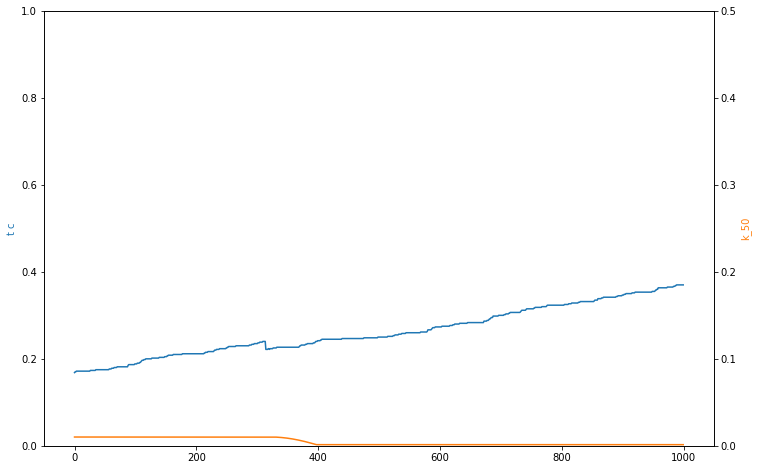

In [24]:

import pandas as pd
import matplotlib.pyplot as plt

# path = os.path.abspath(os.getcwd())
DataFrame = pd.read_csv(resultsFolder + '/results0-tc_a50_k50.csv')

plt.rcParams['figure.figsize'] = [12, 8]
ax1 = DataFrame.tc.plot()
ax1.set_ylim(0, 1)
ax1.set_ylabel('t c', color='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(DataFrame.k_50, color='tab:orange')
ax2.set_ylim(0, 0.5)
ax2.set_ylabel('k_50', color='tab:orange')


In [13]:
# os.chdir('..')
os.getcwd()

'C:\\Users\\tejov\\CivRiseFall_agentmodel2020\\Opinion_Model_Base'

In [14]:
for n in range(len(self.Market)):
    n

NameError: name 'self' is not defined